<a href="https://colab.research.google.com/github/elluy-gabriel-p/Capstone_ML/blob/norma/test3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install tensorflow
!pip install matplotlib
!pip install pillow

In [5]:
# Hapus folder Capstone_ML
!rm -rf Capstone_ML

# Clone repository dari branch norma
!git clone --branch norma https://github.com/elluy-gabriel-p/Capstone_ML.git

# Cek isi folder dataset
!ls Capstone_ML/data/dataset_padang_food

# Path dataset untuk digunakan dalam model
DATASET_PATH = '/content/Capstone_ML/data/dataset_padang_food'

Cloning into 'Capstone_ML'...
remote: Enumerating objects: 1045, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 1045 (delta 20), reused 46 (delta 20), pack-reused 999 (from 1)
Receiving objects: 100% (1045/1045), 171.73 MiB | 31.75 MiB/s, done.
Resolving deltas: 100% (21/21), done.
ayam_goreng  daging_rendang   gulai_ikan     gulai_tunjang  telur_dadar
ayam_pop     dendeng_batokok  gulai_tambusu  telur_balado


**Data preparation and Processing**

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Parameter untuk data
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
DATASET_PATH = '/content/Capstone_ML/data/dataset_padang_food'

# Data Augmentation
datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Memuat data train dan validasi
train_data = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    subset='training',
    class_mode='categorical'
)

validation_data = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    subset='validation',
    class_mode='categorical'
)


Found 799 images belonging to 9 classes.
Found 194 images belonging to 9 classes.


**Buid Model with Transfer Learning**

In [7]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Menggunakan MobileNetV2 sebagai feature extractor
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=IMAGE_SIZE + (3,))
base_model.trainable = False  # Freeze layer

# Menambahkan lapisan khusus untuk klasifikasi
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(train_data.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Tampilkan ringkasan model
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,423,113 (9.24 MB)

 Trainable params: 165,129 (645.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

**Train Model**

In [8]:
# Callback untuk Early Stopping dan Model Checkpoint
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
]

# Melatih model
history = model.fit(
    train_data,
    validation_data=validation_data,
    epochs=15,
    callbacks=callbacks
)


Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.3320 - loss: 1.8862 - val_accuracy: 0.7423 - val_loss: 0.7315
Epoch 2/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.8103 - loss: 0.5684 - val_accuracy: 0.8351 - val_loss: 0.5091
Epoch 3/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.9002 - loss: 0.3164 - val_accuracy: 0.8402 - val_loss: 0.5221
Epoch 4/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.9005 - loss: 0.3165 - val_accuracy: 0.8247 - val_loss: 0.5219
Epoch 5/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.9087 - loss: 0.2456 - val_accuracy: 0.8608 - val_loss: 0.4297
Epoch 6/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.9572 - loss: 0.1844 - val_accuracy: 0.8454 - val_loss: 0.4875
Epoch 7/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.9315 - loss: 0.1884 - val_accuracy: 0.8402 - val_loss: 0.5155
Epoch 8/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.9411 - loss: 0.1871 - val_accuracy: 0.8660 - val_loss: 0.4362
Epo

**Evaluasi Model Keseluruhan**

In [9]:
# Evaluasi pada data validasi
val_loss, val_accuracy = model.evaluate(validation_data)
print(f"Validation Accuracy: {val_accuracy:.2f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8471 - loss: 0.4705
Validation Accuracy: 0.85


**Tes Prediksi Gambar**

In [12]:
import numpy as np
from tensorflow.keras.preprocessing import image

def predict_image(img_path, model, class_indices):
    img = image.load_img(img_path, target_size=IMAGE_SIZE)
    img_array = image.img_to_array(img) / 255.0  # Normalisasi
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]
    class_labels = {v: k for k, v in class_indices.items()}
    return class_labels[predicted_class], prediction[0][predicted_class]

# Mencoba prediksi gambar
img_path = "/content/Capstone_ML/data/dataset_padang_food/ayam_goreng/ayam_goreng (10).jpg"
predicted_class, confidence = predict_image(img_path, model, train_data.class_indices)
print(f"Predicted class: {predicted_class} with confidence: {confidence:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted class: ayam_goreng with confidence: 0.94


**Evaluasi Model Setiap Kelas**

7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step
                 precision    recall  f1-score   support

    ayam_goreng       0.11      0.14      0.12        21
       ayam_pop       0.13      0.14      0.13        22
 daging_rendang       0.17      0.20      0.18        20
dendeng_batokok       0.28      0.24      0.26        21
     gulai_ikan       0.08      0.09      0.09        22
  gulai_tambusu       0.20      0.15      0.17        20
  gulai_tunjang       0.05      0.04      0.05        23
   telur_balado       0.24      0.23      0.23        22
    telur_dadar       0.14      0.13      0.14        23

       accuracy                           0.15       194
      macro avg       0.16      0.15      0.15       194
   weighted avg       0.15      0.15      0.15       194



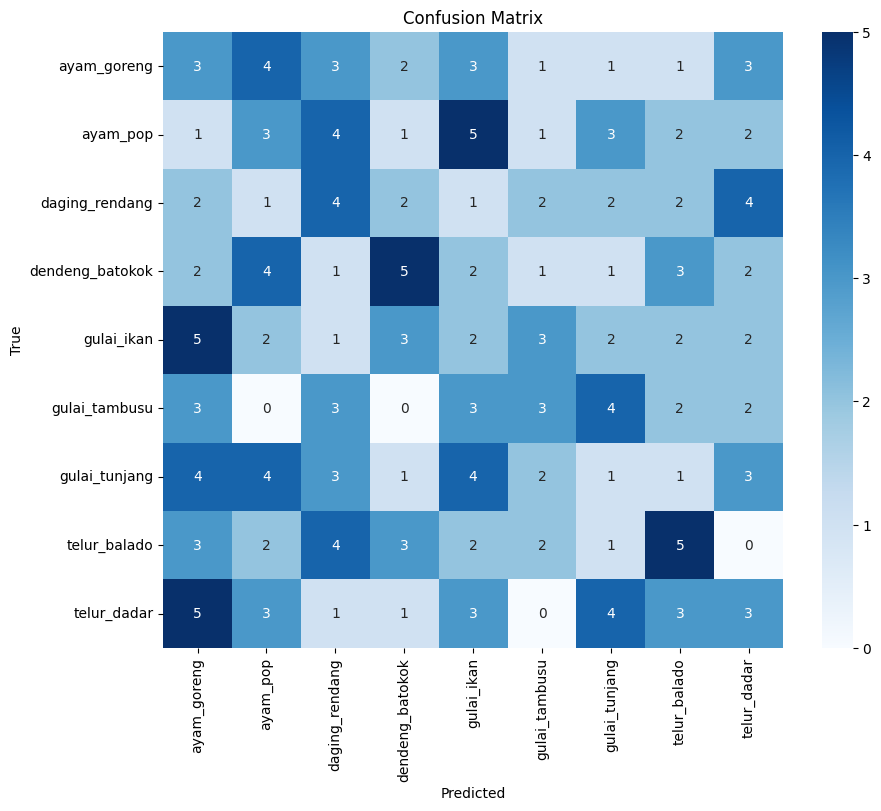

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
Evaluasi Model Setiap Kelas

[13]
25s

# Prediksi seluruh data validasi
validation_data.reset()
predictions = model.predict(validation_data)
y_pred = np.argmax(predictions, axis=1)
y_true = validation_data.classes

# Classification Report
print(classification_report(y_true, y_pred, target_names=validation_data.class_indices.keys()))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=validation_data.class_indices.keys(), yticklabels=validation_data.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
